# Homework

In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import xgboost as xgb

## Preparing the dataset

In [46]:
df = pd.read_csv('jamb_exam_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


- Remove the student_id column.


In [47]:
del df['student_id']

- Fill missing values with zeros.

In [48]:
df = df.fillna(0)

- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.

In [49]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [50]:
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))

# Question 1

Let's train a decision tree regressor to predict the jamb_score variable.

* Train a model with max_depth=1.

Which feature is used for splitting the data?

* study_hours_per_week
* attendance_rate
* teacher_quality
* distance_to_school


In [51]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



A/ `study_hours_per_week`

# Question 2
Train a random forest regressor with these parameters:

* n_estimators=10
* random_state=1
* n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on the validation data?

* 22.13
* 42.13
* 62.13
* 82.12

In [ ]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [56]:
def rmse(y, y_pred):
    squared_error = (y - y_pred)**2
    # average = np.average(squared_error)
    # return np.sqrt(average)
    # mean and average are the same
    mse = np.mean(squared_error)
    return np.sqrt(mse)

In [60]:
y_pred = rf.predict(X_val)
print(round(rmse(y_val, y_pred), 3))

42.137


A/ `42.13`

# Question 3
Now let's experiment with the n_estimators parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set random_state to 1.
* Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.
* 10
* 25
* 80
* 200

In [69]:
for n_estimators in np.arange(10, 210, 10):
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    print(n_estimators, "=>", round(rmse(y_val, y_pred), 3))

10 => 42.137
20 => 41.461
30 => 41.106
40 => 40.917
50 => 40.852
60 => 40.784
70 => 40.677
80 => 40.539
90 => 40.504
100 => 40.517
110 => 40.593
120 => 40.625
130 => 40.651
140 => 40.595
150 => 40.597
160 => 40.604
170 => 40.628
180 => 40.641
190 => 40.631
200 => 40.601


A/ `80`

# Question 4

Let's select the best max_depth:

* Try different values of max_depth: [10, 15, 20, 25]
* For each of these values,
    * try different values of n_estimators from 10 till 200 (with step 10)
    * calculate the mean RMSE
* Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

* 10
* 15
* 20
* 25

In [111]:
scores = []
for max_depth in [10, 15, 20, 25]:
    for n_estimators in np.arange(10, 210, 10):
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        scores.append([max_depth, n_estimators, round(rmse(y_val, y_pred), 3)])

df_scores = pd.DataFrame(data=scores, columns=['max_depth', 'n_estimators', 'rmse'])
df_scores[df_scores['rmse'] == df_scores['rmse'].min()]


,max_depth,n_estimators,rmse
8,10,90,40.174


In [112]:

for max_depth in [10, 15, 20, 25]:
    scores = []
    for n_estimators in np.arange(10, 210, 10):
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        scores.append(round(rmse(y_val, y_pred), 3))
    print(max_depth, '=>', np.array(scores).mean())

10 => 40.3924
15 => 40.73535
20 => 40.739700000000006
25 => 40.787850000000006


A/ `10`

# Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
    * n_estimators=10,
    * max_depth=20,
    * random_state=1,
    * n_jobs=-1 (optional)

* Get the feature importance information from this model

What's the most important feature (among these 4)?
* study_hours_per_week
* attendance_rate
* distance_to_school
* teacher_quality

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28],
 [Text(0, 0, 'access_to_learning_materials=No'),
  Text(1, 0, 'access_to_learning_materials=Yes'),
  Text(2, 0, 'age'),
  Text(3, 0, 'assignments_completed'),
  Text(4, 0, 'attendance_rate'),
  Text(5, 0, 'distance_to_school'),
  Text(6, 0, 'extra_tutorials=No'),
  Text(7, 0, 'extra_tutorials=Yes'),
  Text(8, 0, 'gender=Female'),
  Text(9, 0, 'gender=Male'),
  Text(10, 0, 'it_knowledge=High'),
  Text(11, 0, 'it_knowledge=Low'),
  Text(12, 0, 'it_knowledge=Medium'),
  Text(13, 0, 'parent_education_level'),
  Text(14, 0, 'parent_education_level=Primary'),
  Text(15, 0, 'parent_education_level=Secondary'),
  Text(16, 0, 'parent_education_level=Tertiary'),
  Text(17, 0, 'parent_involvement=High'),
  Text(18, 0, 'parent_involvement=Low'),
  Text(19, 0, 'parent_involvement=Medium'),
  Text(20, 0, 'school_location=Rural'),
  Text(

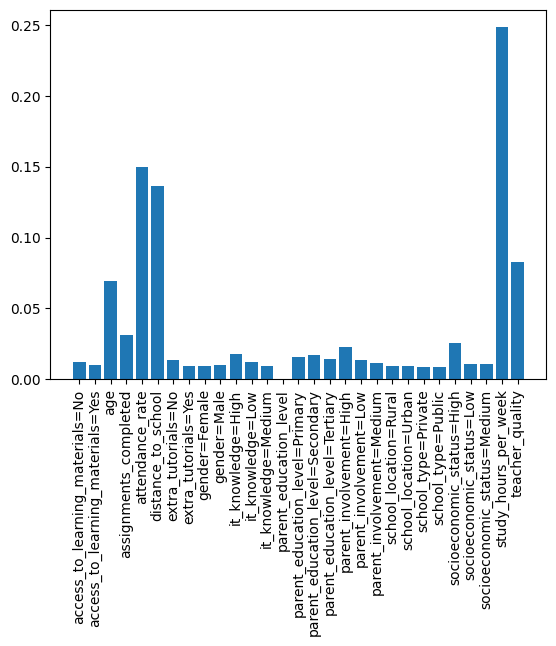

In [ ]:
n_estimators = 10
max_depth = 20
random_state = 1
n_jobs = -1

rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
rf.fit(X_train, y_train)


plt.bar(dv.get_feature_names_out(), rf.feature_importances_)
plt.xticks(rotation=90)

A/ `study_hours_per_week`

# Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [145]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [146]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(features))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(features))
watchlist = [(dtrain, 'train'), (dval, 'val')]
output = ''
scores = {}


In [150]:
xgb_params = {
        'eta': 0.1, 
        'max_depth': 6,
        'min_child_weight': 1,
    
        'objective': 'reg:squarederror',
        'nthread': 8,
    
        'seed': 1,
        'verbosity': 1,
}

In [151]:
%%capture output

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [152]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [ ]:
print('eta=0.3', '=>', round(scores['eta=0.3']['val_rmse'].mean(), 3))

eta=0.3 => 42.411


In [158]:
print('eta=0.1', '=>', round(scores['eta=0.1']['val_rmse'].mean(), 3))

eta=0.1 => 40.964


A/ `0.1`